# RUL and SOH Estimator

## Data Description:

    A set of four Li-ion batteries (# 45 - 48) were run through 3 different operational profiles (charge, discharge and impedance) at an ambient temperature of 4 deg C. 
    Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. 
    "Fixed load current level of 1A" was used and the discharge runs were stopped at 2V, 2.2V, 2.5V and 2.7V for batteries 45, 46, 47 and 48 respectively.
    Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz. The experiments were carried out until the capacity had reduced to 1.4Ahr (30% fade). 
    Note that there are several discharge runs where the capacity was very low. Reasons for this have not been fully analyzed.

### Files:
    B0047.mat	Data for Battery #47

## Data Structure:
    cycle-	top level structure array containing the charge, discharge and impedance operations
	type: 	operation  type, can be charge, discharge or impedance
	ambient_temperature:	ambient temperature (degree C)
	time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	data:	data structure containing the measurements
#### for charge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at charger (Amps)
		Voltage_charge:		Voltage measured at charger (Volts)
		Time:			Time vector for the cycle (secs)
#### for discharge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at load (Amps)
		Voltage_charge:		Voltage measured at load (Volts)
		Time:			Time vector for the cycle (secs)
		Capacity:		Battery capacity (Ahr) for discharge till 2.7V
#### for impedance the fields are:
		Sense_current:		Current in sense branch (Amps)
		Battery_current:	Current in battery branch (Amps)
		Current_ratio:		Ratio of the above currents
		Battery_impedance:	Battery impedance (Ohms) computed from raw data
		Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms)
		Re:			Estimated electrolyte resistance (Ohms)
		Rct:			Estimated charge transfer resistance (Ohms)
##### link: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

        DF - DataFrame
        DT - DataType
        MAE -Mean Absolute error 
        RMSE - Root Mean Square error

## Modules to be imported

In [1]:
import scipy.io
import pandas
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet,Ridge
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from math import sqrt

sns.set()

## Battery Datasets

In [2]:
bat1=pd.read_csv('B0045 .csv')
bat2=pd.read_csv('B0046 .csv')
bat3=pd.read_csv('B0047.csv')
bat4=pd.read_csv('B0048.csv')

In [3]:
soh_df=pd.concat([bat1,bat2,bat3,bat4])
soh_df.to_csv('dataset.csv')
soh_df

,Unnamed: 0,cycle,max_distemp,max_chtemp,capacity,dis_time,chr_time,Discharge_voltage,Discharge_current,Discharge_min_Threshold_voltage_time,Charging_max_Threshold_voltage_time,Discharge_min_Threshold_voltage_temp,Charging_max_Threshold_voltage_temp,SOH,RUL
0,0,1,15.710390,8.785650,1.081979,6436.141,10803.313,2.0,1,4348.625,159.344,15.636714,4.782260,1.000000,72
1,1,2,16.327882,8.853130,0.927952,5650.265,10802.078,2.0,1,3851.453,147.218,16.323712,4.567414,0.857643,71
2,2,3,16.190453,8.776292,0.885194,5590.907,10807.688,2.0,1,3698.235,128.907,16.177597,4.385074,0.818124,70
3,3,4,16.445646,8.775347,0.858101,5543.610,10805.687,2.0,1,3589.813,123.312,16.445646,4.513285,0.793084,69
4,4,5,16.652822,8.718063,0.840935,5499.046,10804.078,2.0,1,3502.375,123.719,16.547100,3.995360,0.777219,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,67,68,11.147240,9.266094,1.269122,4663.907,10807.969,2.7,1,4602.078,455.390,9.860019,7.251271,0.765456,5
65,68,69,10.831286,9.769486,1.255514,4581.328,10809.594,2.7,1,4550.391,52.250,10.119056,5.724068,0.757248,4
66,69,70,11.236293,9.485689,1.251988,4553.031,10804.109,2.7,1,4537.609,334.203,10.138374,6.865545,0.755121,3
67,70,71,11.086170,10.803093,1.237498,4486.500,10810.344,2.7,1,4486.500,600.704,11.086170,8.605278,0.746382,2


In [30]:
soh_df['dis_time'].min()

3581.188

In [34]:
soh_df['dis_time'].max()

6436.141

In [32]:
soh_df['Discharge_min_Threshold_voltage_time'].min()

2682.015

In [33]:
soh_df['Discharge_min_Threshold_voltage_time'].max()

6436.141

# State of Health Prediction

## Mutual Information

In [4]:
inputs=soh_df[['cycle', 'max_distemp', 'max_chtemp', 'dis_time',
       'chr_time', 'Discharge_voltage', 'Discharge_current',
       'Discharge_min_Threshold_voltage_time',
       'Charging_max_Threshold_voltage_time',
       'Discharge_min_Threshold_voltage_temp',
       'Charging_max_Threshold_voltage_temp']]
outputs=soh_df['SOH']

<AxesSubplot:>

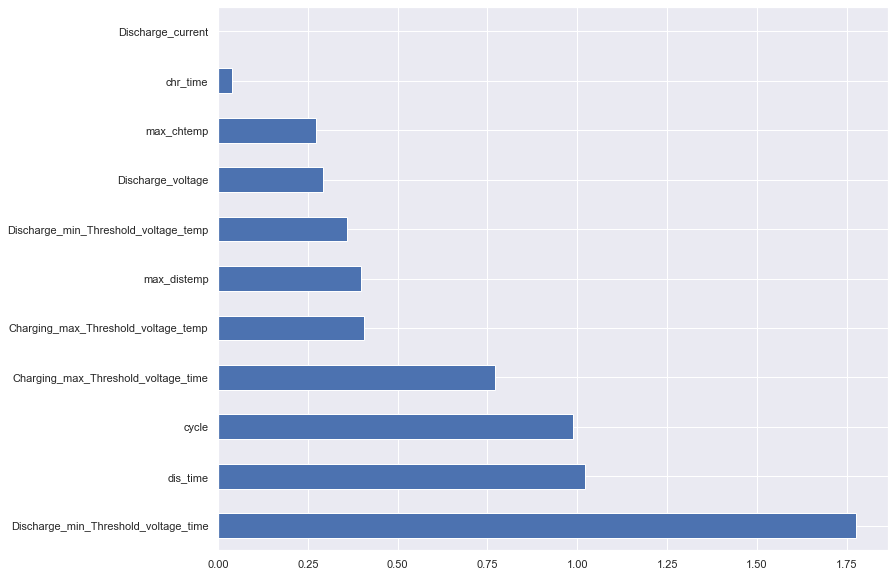

In [5]:
from sklearn.feature_selection import mutual_info_regression
mutal_info=mutual_info_regression(inputs,outputs)
mutal_info=pd.Series(mutal_info)
mutal_info.index=inputs.columns
mutal_info.sort_values(ascending=False)
mutal_info.sort_values(ascending=False).plot.barh(figsize=(12,10))

From above graph Discharge_min_threshold_voltage_time and dis_time is more mutual to SOH than other features. 
But Discharge_min_threshold_voltage_time gives us detailed view so we are taking this feature.

### Feature selection for SOH

Features normally considered for SOH\
    * Voltage\
    * Time\
    * Current\
    * Temperature
    
current-constant (doesn't affect much)\
Temperature (Doesn't affect much because of Ambient/room temperature 4 deg celsius)

    Dropping columns:
    
        cycle -> which is directly correlated with SOH
        capacity -> which is as same as SOH
        max_distemp, max_chtemp, Charging_max_Threshold_voltage_temp, Discharge_min_Threshold_voltage_temp-> Temperature factor is not affecting SOH mostly because of Ambient/room temperature 4 deg celsius it can't cause battery to heat much.
        if Ambient is high, temperature factor will affect the SOH prediction
        dis_time, chr_time -> we drop these features because charge, discharge voltage values doesn't give exact explaination of charging and discharging than Charging_max_Threshold_voltage and Discharge_min_Threshold_voltage.
        
        
    Features selected:
    
        Discharge_min_Threshold_voltage_time
        Charging_max_Threshold_voltage_time
        Charging_max_Threshold_voltage_time(Sec) and Discharge_min_Threshold_voltage_time(Sec) both feature gives exact time taken for voltage to attain 4.2 max threshold while charging and gives exact time taken for voltage to attain 2.5 voltage drop threshold while discharging respectively which gives more detailed estimation for capacity.


    Discharge_min_Threshold_voltage_time,Charging_max_Threshold_voltage_time are Time values with respect to voltage 
    In these we considered both Voltage and Time for charging and discharging.

    SOH prediction,we cannot able to predict SOH directly.So we are going for Indirect Health Indicators(IHI) for charge,current,and temperature curves as input features and finaly we are selecting best input features in that.
    
    
    Discharge_min_threshold_voltage_time is more than enough for SOH prediction, we need both charge and discharge for battery to know more about battery estimation and it is better to have both features. 

### Discahrge_min_Threshold_voltage_time

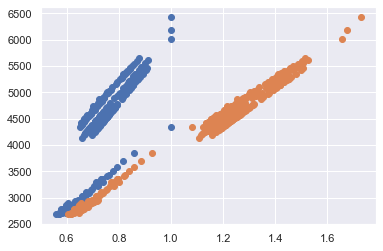

In [6]:
plt.scatter(soh_df['SOH'],soh_df['Discharge_min_Threshold_voltage_time'])
plt.scatter(soh_df['capacity'],soh_df['Discharge_min_Threshold_voltage_time'])

When the capacity and SOH increase Discharge_min_Threshold_voltage_time also increase.
It is correlated with capacity and SOH.
 Discharge_min_Threshold_voltage_time(Sec) feature gives exact time taken for voltage to attain 2.5 voltage drop threshold while discharge which gives more detailed estimation for capacity.


### Charging_max_Threshold_voltage_time

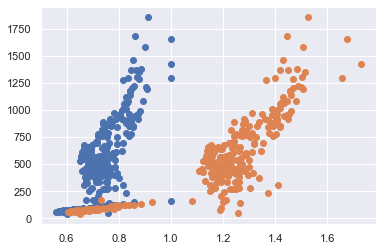

In [7]:
plt.scatter(soh_df['SOH'],soh_df['Charging_max_Threshold_voltage_time'])
plt.scatter(soh_df['capacity'],soh_df['Charging_max_Threshold_voltage_time'])

When the capacity and SOH increase Charging_max_Threshold_voltage_time also increase.
It is correlated with capacity and SOH.

Charging_max_Threshold_voltage_time(Sec) feature gives exact time taken for voltage to attain 4.2 max threshold while charging which gives more detailed estimation for capacity.


### Model selection for SOH

        Model                r2_score           Mean Absolute error(MAE)       Root mean Square error(RMSE)
        
        
     
     LinearRegression    0.99756192078892       0.0026904860747766165          0.0035585476728445882
     
     SVR                 0.9906417766713533     0.005747891069886788           0.006971810678756418
     
     Ridge               0.9693625454576208     0.010266501242172012           0.012614650502126604
     
     LinearRegression    0.9980478953255226     0.00239270731079238            0.0031842006989559165
     (Polynomial Features
     deg -2)
     
From above table Linear regression with polynomial features is good model because of low MAE and RMSE



    

### Linear Regression - Polynomial Features

Feature scaling

In [8]:
x=soh_df.drop(['capacity','dis_time','chr_time','cycle','max_chtemp','max_distemp','SOH','Discharge_current',"RUL",'Discharge_min_Threshold_voltage_temp','Charging_max_Threshold_voltage_temp','Unnamed: 0','Charging_max_Threshold_voltage_time'],axis=1)
print(x.columns)
y=soh_df['SOH']
minmax=MinMaxScaler()
x=minmax.fit_transform(x)

Index(['Discharge_voltage', 'Discharge_min_Threshold_voltage_time'], dtype='object')


Train Test Data split

In [9]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.15,random_state=32)

Getting polynomial Features for X

In [10]:
poly_reg = PolynomialFeatures(degree=4)
x_poly = poly_reg.fit_transform(x_train)

LinearRegression Model object

In [11]:
lin_reg = LinearRegression()

Fitting model

In [12]:
lin_reg.fit(x_poly, y_train)

LinearRegression()

Predicting SOH for train,test and Total value

In [13]:
y_pred = lin_reg.predict(poly_reg.transform(x))
y_pred_train = lin_reg.predict(poly_reg.transform(x_train))
y_pred_test = lin_reg.predict(poly_reg.transform(x_test))

Calculating r2_score,MAE and RMSE

In [14]:
print('r2 score train',r2_score(y_train,y_pred_train))
print('r2 score test',r2_score(y_test,y_pred_test))
print('r2 score ',r2_score(y,y_pred))
print('Root mean square error',sqrt(mean_squared_error(y,y_pred)))
print('mean absolute error',mean_absolute_error(y,y_pred))

r2 score train 0.9964307559153438
r2 score test 0.9904459971466757
r2 score  0.9959586678405902
Root mean square error 0.005421186863186128
mean absolute error 0.0030687038036274986


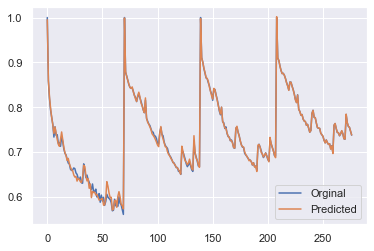

In [15]:
plt.plot(list(y))
plt.plot(list(y_pred))
plt.legend(labels=['Orginal','Predicted'])

### Hyperparameter tuning

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold,GridSearchCV
from sklearn.pipeline import Pipeline
models = dict()
for d in range(1,11):
# define the pipeline
    trans = PolynomialFeatures(degree=d)
    model = LinearRegression()
    models[str(d)] = Pipeline(steps=[('t', trans), ('m', model)])
models

{'1': Pipeline(steps=[('t', PolynomialFeatures(degree=1)), ('m', LinearRegression())]),
 '2': Pipeline(steps=[('t', PolynomialFeatures()), ('m', LinearRegression())]),
 '3': Pipeline(steps=[('t', PolynomialFeatures(degree=3)), ('m', LinearRegression())]),
 '4': Pipeline(steps=[('t', PolynomialFeatures(degree=4)), ('m', LinearRegression())]),
 '5': Pipeline(steps=[('t', PolynomialFeatures(degree=5)), ('m', LinearRegression())]),
 '6': Pipeline(steps=[('t', PolynomialFeatures(degree=6)), ('m', LinearRegression())]),
 '7': Pipeline(steps=[('t', PolynomialFeatures(degree=7)), ('m', LinearRegression())]),
 '8': Pipeline(steps=[('t', PolynomialFeatures(degree=8)), ('m', LinearRegression())]),
 '9': Pipeline(steps=[('t', PolynomialFeatures(degree=9)), ('m', LinearRegression())]),
 '10': Pipeline(steps=[('t', PolynomialFeatures(degree=10)),
                 ('m', LinearRegression())])}

Setting pipeline for degrees in polynomial feature

In [17]:
def evaluate_model(model, x, y):   
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    parameters = {}
    search = GridSearchCV(model, parameters, n_jobs=-1, cv=cv)
    result = search.fit(x, y)
    return result


# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, x, y)
    print("Degree:",name,', Score :',scores.best_score_,', n_splits:',scores.n_splits_)

Degree: 1 , Score : 0.6492141107870043 , n_splits: 30
Degree: 2 , Score : 0.847114925933245 , n_splits: 30
Degree: 3 , Score : 0.9940646257083762 , n_splits: 30
Degree: 4 , Score : 0.9941047739496361 , n_splits: 30
Degree: 5 , Score : 0.9939118526021636 , n_splits: 30
Degree: 6 , Score : 0.98573676171598 , n_splits: 30
Degree: 7 , Score : 0.16028355387171436 , n_splits: 30
Degree: 8 , Score : -0.6501816796081086 , n_splits: 30
Degree: 9 , Score : -73.83393769915389 , n_splits: 30
Degree: 10 , Score : -3941.862369912054 , n_splits: 30


From above shell we can say degree - 2 is best 

# Remaining Cycle Prediction

## Mutual Information

In [18]:
inputs=soh_df[[ 'max_distemp', 'max_chtemp', 'dis_time',
       'chr_time', 'Discharge_voltage', 'Discharge_current',
       'Discharge_min_Threshold_voltage_time',
       'Charging_max_Threshold_voltage_time',
       'Discharge_min_Threshold_voltage_temp',
       'Charging_max_Threshold_voltage_temp',"SOH"]]
outputs=soh_df['RUL']

<AxesSubplot:>

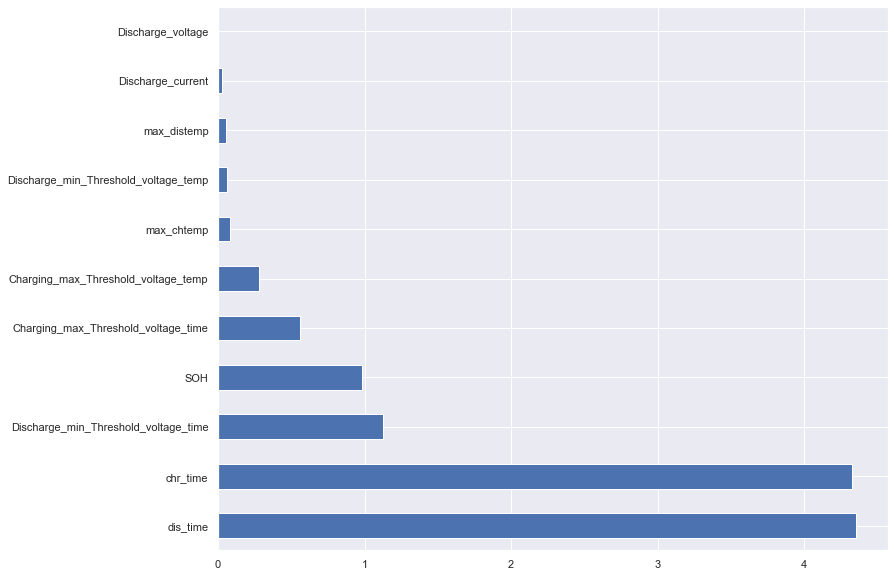

In [19]:
from sklearn.feature_selection import mutual_info_regression
mutal_info=mutual_info_regression(inputs,outputs)
mutal_info=pd.Series(mutal_info)
mutal_info.index=inputs.columns
mutal_info.sort_values(ascending=False)
mutal_info.sort_values(ascending=False).plot.barh(figsize=(12,10))

From above graph Discharge_min_threshold_voltage_time and dis_time is more mutual to RUL than other features. 
But Discharge_min_threshold_voltage_time gives us detailed view so we are taking this feature.

### Feature selection for RUC


Features normally considered for RUC\
    * Voltage\
    * Time\
    * Current\
    * Temperature\
    * Capacity
    
current-constant (doesn't affect much)\
Temperature (Doesn't affect much because of Ambient/room temperature 4 deg celsius)

    Dropping columns:
    
        cycle -> which is directly correlated with RUL
        max_distemp, max_chtemp, Charging_max_Threshold_voltage_temp, Discharge_min_Threshold_voltage_temp-> Temperature factor is not affecting SOH mostly because of Ambient/room temperature 4 deg celsius it can't cause battery to heat much.
        if Ambient is high, temperature factor will affect the SOH prediction
        chr_time -> we drop these features because charge, discharge voltage values doesn't give exact explaination of charging and discharging than Charging_max_Threshold_voltage and Discharge_min_Threshold_voltage.
        
        
        
    Features selected:
        
        capacity is required but we are using SOH because which is as same as capacity.
        so SOH Feature is more than enough to predict the model.
        Discharge_min_Threshold_voltage_time
        Charging_max_Threshold_voltage_time
        Charging_max_Threshold_voltage_time(Sec) and Discharge_min_Threshold_voltage_time(Sec) both feature gives exact time taken for voltage to attain 4.2 max threshold while charging and gives exact time taken for voltage to attain 2.5 voltage drop threshold while discharging respectively which gives more detailed estimation for capacity.


Discharge_min_Threshold_voltage_time,Charging_max_Threshold_voltage_time are Time values with respect to voltage 
In these we considered both Voltage and Time for charging and discharging.

### Cycle vs Capacity

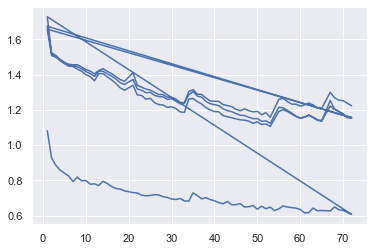

In [20]:
plt.plot(soh_df['cycle'],soh_df['capacity'])
plt.show()

The discharge capacity of the battery cells cycled at different cycling number shows that the battery’s performances become worse with the increasing of cycling number.

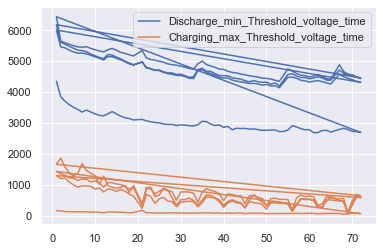

In [21]:
plt.plot(soh_df['cycle'],soh_df['Discharge_min_Threshold_voltage_time'],label='Discharge_min_Threshold_voltage_time')
plt.plot(soh_df['cycle'],soh_df['Charging_max_Threshold_voltage_time'],label='Charging_max_Threshold_voltage_time')
plt.legend(labels=['Discharge_min_Threshold_voltage_time','Charging_max_Threshold_voltage_time'])
plt.show()

The diagram shows the continuous reduction in minimum threshold voltage time of discharging with respective cycle.So cycle depends on minimum threshold voltage too.
This picture shows the gradual decrease in maximum threshold voltage time of charging with respective cycle.So cycle depends on maximum threshold voltage

### Model selection for SOH

        Model                r2_score           Mean Absolute error(MAE)       Root mean Square error(RMSE)
        
        
     
     LinearRegression    0.8509796174988952     6.196367128165051              8.000302077948735
     
     SVR                 0.17236536161325533    16.197060498562497             18.853972874667864
     
     SVR(linear)         0.7474845507784984     6.854289933884003              10.414238649540584
     
     SVR(poly)           0.591608072321542      10.276147454218194             13.244089996751326
     
     SVR(rbf)            0.898527711786203      4.220919979033104              6.601722660229034
     
     Ridge               0.7860445780525692     7.009061952134607              9.586171556006965
     
     Lasso               0.7860070259108836     7.0093710681045405             9.587012772077065
     
     ElasticNet          0.785996657821251      7.009566070393674              9.587245017561282
     
     LinearRegression    0.8988387955474056     4.442995733473573              6.591595436489932
     (Polynomial Features
     deg -2)
     
     
    
    1)From above table SVR(rbf) and polynomial regression had higher r2_score have more over same r2_score.
    2)While Predicting Dynamic data SVR gives better prediction value then polynomial regression. 

### SVR

Feature scaling

In [22]:
x=soh_df.drop(['capacity','chr_time','cycle','max_chtemp','max_distemp','Discharge_current',"RUL",'Discharge_min_Threshold_voltage_temp','Charging_max_Threshold_voltage_temp','Unnamed: 0','Charging_max_Threshold_voltage_time'],axis=1)
print(x.columns)
y=soh_df['RUL']
minmax=MinMaxScaler()
x=minmax.fit_transform(x)

Index(['dis_time', 'Discharge_voltage', 'Discharge_min_Threshold_voltage_time',
       'SOH'],
      dtype='object')


Train Test Data split

In [23]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.15,random_state=32)

Hyper tuning

In [24]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# Parameters for tuning
parameters = [{'kernel': ['rbf','linear','poly'], 'epsilon':[0.1,1,0.01,0.001,10,0.0001],'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.7,0.8,0.9],'C': [1, 10, 100, 1000, 10000,0.1]}]
print("Tuning hyper-parameters")
svr = GridSearchCV(SVR(), parameters, cv = cv)
svr.fit(x, y)
svr.best_params_

'cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)\n# Parameters for tuning\nparameters = [{\'kernel\': [\'rbf\',\'linear\',\'poly\'], \'epsilon\':[0.1,1,0.01,0.001,10,0.0001],\'gamma\': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.7,0.8,0.9],\'C\': [1, 10, 100, 1000, 10000,0.1]}]\nprint("Tuning hyper-parameters")\nsvr = GridSearchCV(SVR(), parameters, cv = cv)\nsvr.fit(x, y)\nsvr.best_params_'

LinearRegression Model object

In [25]:
svr = SVR(kernel='rbf',epsilon=1,C=10000,gamma=0.9)

Fitting model

In [26]:
svr.fit(x_train, y_train)

SVR(C=10000, epsilon=1, gamma=0.9)

Predicting SOH for train,test and Total value

In [27]:
y_pred = svr.predict(x)
y_pred_train = svr.predict(x_train)
y_pred_test = svr.predict(x_test)

Calculating r2_score,MAE and RMSE

In [28]:
print('r2 score train',r2_score(y_train,y_pred_train))
print('r2 score test',r2_score(y_test,y_pred_test))
print('r2 score ',r2_score(y,y_pred))
print('Root mean square error',sqrt(mean_squared_error(y,y_pred)))
print('mean absolute error',mean_absolute_error(y,y_pred))

r2 score train 0.9215492962231382
r2 score test 0.9127548849622444
r2 score  0.920888588727143
Root mean square error 5.8264568623920185
mean absolute error 3.6312734685365595


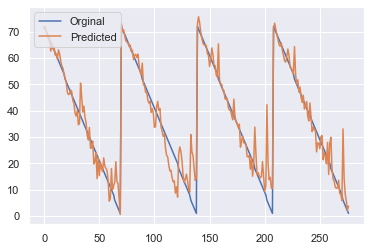

In [29]:
plt.plot(list(y))
plt.plot(list(y_pred))
plt.legend(labels=['Orginal','Predicted'])

# END 